# Black Lives Matter: Topic Modeling

This analysis was inspired by the [_Topic Modeling with Gensim (Python)_ post](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/), which can be found on the Machine Learning Plus blog.

## Import libraries

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rosarodriguez/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import random

In [5]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [10]:
# spacy for lemmatization
import spacy

In [8]:
# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [7]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [9]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'amp'])

## Import data

In [11]:
from google.cloud import bigquery
from google.oauth2 import service_account

In [10]:
#%env GOOGLE_APPLICATION_CREDENTIALS = ../dsi-capstone-f19-group-1-670a48d72abe.json

env: GOOGLE_APPLICATION_CREDENTIALS=../dsi-capstone-f19-group-1-670a48d72abe.json


In [12]:
%env GOOGLE_APPLICATION_CREDENTIALS = ../dsi-capstone-f19-group-1-198add732865.json

env: GOOGLE_APPLICATION_CREDENTIALS=../dsi-capstone-f19-group-1-198add732865.json


In [13]:
%load_ext google.cloud.bigquery

In [14]:
%%bigquery df
SELECT
    DISTINCT LOWER(full_text) AS full_text
FROM tweets.all_valid_tweets
WHERE ferguson_ht + michael_brown = 2
    AND full_text NOT LIKE 'RT @%'
    AND full_text NOT LIKE '"@%'
    AND full_text NOT LIKE '“@%'
    AND lang = 'en'

In [15]:
data = list(df['full_text'])

## Pre-processing tweets

### URLs

A lot of tweets include links to other websites, for instance, news and articles. This _URLs_ cannot be considered words and is hard to know where are they pointing, because the text that appears is usually an encrypted version. However, just the fact that the tweet includes a link can be useful for our analysis. Therefore, we will replace any URL with the _http_ word. 

That means that 

_Bridge March over Troubled Water http://t.co/Sh5ToZy6PF #AlSharpton #StatenIsland #EricGarner #Verrazano_ 

now becomes 

_Bridge March over Troubled Water http #AlSharpton #StatenIsland #EricGarner #Verrazano_.

In [16]:
# Remove URLs
original_num = len(data)
data = [re.sub("\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*", "", sent) for sent in data]
data = list(set(data))
data = [x for x in data if str(x) != 'nan' and str(x)]
unique_http_num = len(data)
unique_http_perc = round(100.0 * unique_http_num  / original_num)
print('Accordingly, the number of tweets now reduces to %d. That means %d out of 100 of the original ones.' % (unique_http_num, unique_http_perc))

Accordingly, the number of tweets now reduces to 169408. That means 94 out of 100 of the original ones.


### Remove new lines _\n_

The are some tweets where the user typed _Enter_ to start a new line. This is translated into the _\n_ character, which can create confusion when we are separating words. Consequently, we will replace those characters with ' '.

In [17]:
data = [re.sub("\n", " ", sent) for sent in data]
data = list(set(data))
data = [x for x in data if str(x) != 'nan' and str(x)]
len(data)

169315

### Decompose into bag of words

Let's take a tweet in our data:

In [18]:
tweet = 'News: Man who shot video of Eric Garner in apparent choke hold arrested on firearms charges.'
print(tweet)

News: Man who shot video of Eric Garner in apparent choke hold arrested on firearms charges.


Now we will decompose this tweet into an array of words, where the order doesn't matter.

In [19]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
def unique_list_of_lists(lol):
    unique_lol = set(map(tuple, lol))
    unique_lol = list(map(list, unique_lol))
    return(unique_lol)
    
data_words = list(sent_to_words(data))

#Example
tweet_words = list(sent_to_words([tweet]))
print(tweet_words[0])

['news', 'man', 'who', 'shot', 'video', 'of', 'eric', 'garner', 'in', 'apparent', 'choke', 'hold', 'arrested', 'on', 'firearms', 'charges']


### Stop words

There are commonly used words (such as “the”, “a”, “an”, “in”) which appear that often, that are useless to understand the context we are analyzing. Moreover, since they are common, they make the NLP techniques to spend more time processing, without adding any value. Therefore, we will remove them from every tweet.

In [20]:
stop_words.extend(['ferguson', 'michael', 'mike', 'brown', 'michaelbrown', 'mikebrown'])
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Remove Stop Words
data_words_nostops = unique_list_of_lists(remove_stopwords(data_words))

#Example
tweet_words_nostops = remove_stopwords(tweet_words)
print(tweet_words_nostops[0])

['news', 'man', 'shot', 'video', 'eric', 'garner', 'apparent', 'choke', 'hold', 'arrested', 'firearms', 'charges']


In [21]:
len(unique_list_of_lists(data_words_nostops)) / len(data_words)

0.9581017629861501

In [22]:
len(data_words_nostops) / len(data)

0.9581017629861501

### Bigrams and Trigrams

There are concepts like _Eric Garner_ or _New York_ which make more sense to be analyzed as a single word, than being split into two. To achieve that we will use the concept of bigrams and trigrams.

In [23]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=20)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [24]:
def make_bigrams(texts):
    return [remove_underscore(bigram_mod[doc]) for doc in texts]

def make_trigrams(texts):
    return [remove_underscore(trigram_mod[bigram_mod[doc]]) for doc in texts]

def remove_underscore(doc):
    return([re.sub("_", "", word) for word in doc])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [27]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Example
tweet_words_bigrams = make_bigrams(tweet_words_nostops)
print(tweet_words_bigrams[0])

['news', 'man', 'shot', 'video', 'ericgarner', 'apparent', 'choke', 'hold', 'arrested', 'firearms', 'charges']


### Lemmatization

Finally, we would like to tackle one last challenge: The fact that a word used as a singular or plural should be considered the same. Similar case when you conjugate a verb or you use verbs and adjectives with the same origin. 

These kinds of problems are solved by _Lemmatization_ , a technique that transforms any single word to its root.

In [28]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Example
tweet_lemmatized = lemmatization(tweet_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(tweet_lemmatized[0])

['news', 'man', 'shoot', 'video', 'ericgarner', 'apparent', 'choke', 'hold', 'arrest', 'firearm', 'charge']


## Modeling topics

### Build corpora

Once we have the pre-processed tweets we want to model, we need to make them comparable on a mathematical way. To achieve that, we will create as many dimensions as we have unique words in the set of tweets. Then, we will assign to each word the number of times it was mentioned in the tweet (and zero if it didn't appear).

In [29]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Example
print(id2word.doc2bow(tweet_lemmatized[0]))

[(24, 1), (44, 1), (123, 1), (136, 1), (206, 1), (399, 1), (400, 1), (431, 1), (2242, 1), (4650, 1), (6916, 1)]


In [30]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in [id2word.doc2bow(tweet) for tweet in tweet_lemmatized]]

[[('video', 1),
  ('ericgarner', 1),
  ('news', 1),
  ('arrest', 1),
  ('shoot', 1),
  ('charge', 1),
  ('man', 1),
  ('hold', 1),
  ('firearm', 1),
  ('apparent', 1),
  ('choke', 1)]]

### LDA Mallet Model

To model the different topics, we are going to use the Latent Dirichlet Allocation (LDA) technique. Specifically, we are going to use the Mallet implementation, which is a Java-based package for statistical NLP.

In [31]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(
    mallet_path,
    corpus=corpus,
    num_topics=10,
    id2word=id2word,
    alpha=1,
    optimize_interval=50,
    workers=7,
    random_seed=2019
)

This will give us 10 different topics (a fixed parameter we used). Now, we are going to explore the 10 words most representative of each of these topics. 

In [32]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('live', 0.022178291943992793),
   ('watch', 0.0221081074758156),
   ('video', 0.01046918316976453),
   ('news', 0.0104457883470388),
   ('livestream', 0.009802430722081203),
   ('cnn', 0.009229257565300799),
   ('tweet', 0.009053796394857818),
   ('coverage', 0.008854940401689106),
   ('story', 0.008796453344874779),
   ('share', 0.008246675010820105)]),
 (1,
  [('police', 0.07739938080495357),
   ('officer', 0.06299319302415278),
   ('darrenwilson', 0.03367003367003367),
   ('shoot', 0.0329611908559277),
   ('kill', 0.027040268526336637),
   ('release', 0.01885730368702505),
   ('cop', 0.01774191867071124),
   ('chief', 0.01762725292137057),
   ('shot', 0.015438179524866832),
   ('murder', 0.013144864538053393)]),
 (2,
  [('people', 0.01864747371248371),
   ('police', 0.013777941366652408),
   ('cop', 0.013280542761358097),
   ('black', 0.013131323179769804),
   ('make', 0.008833799230026959),
   ('murder', 0.008744267481073983),
   ('kill', 0.008654735732121006),
   ('white'

Finally, we will obtain the coherence score, a metric that will indicate how good the model fit is.

In [33]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.3579830136892574


### Choosing the number of topics

As we mentioned before, the number of topics was fixed to 10. However, we would like to optimize that hyper-parameter as well to improve the model performance. To achieve that we will use the Coherence Score, trying different values, and analyzing which is the one with the best performance.

In [34]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(
            mallet_path,
            corpus=corpus,
            num_topics=num_topics,
            id2word=id2word,
            alpha=1,
            optimize_interval=50,
            workers=7,
            random_seed=2019
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [35]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=22, step=2)

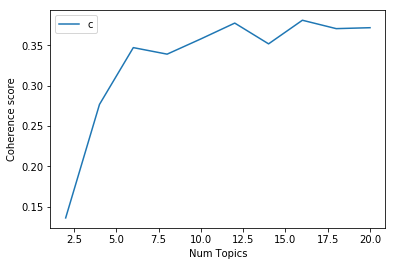

In [36]:
# Show graph
limit=22; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [37]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.1362
Num Topics = 4  has Coherence Value of 0.2768
Num Topics = 6  has Coherence Value of 0.3472
Num Topics = 8  has Coherence Value of 0.3391
Num Topics = 10  has Coherence Value of 0.358
Num Topics = 12  has Coherence Value of 0.3776
Num Topics = 14  has Coherence Value of 0.3518
Num Topics = 16  has Coherence Value of 0.3811
Num Topics = 18  has Coherence Value of 0.3707
Num Topics = 20  has Coherence Value of 0.3718


### Working with the optimal model

The model we liked the most was the one with 8 topics. Although the 4-theme model has the best performance, the 8-theme balances the diversity of topics with acceptable performance.

In [38]:
optimal_model = model_list[5]

In [39]:
# Print the topics
pprint(optimal_model.show_topics(formatted=False, num_topics=20))

[(0,
  [('family', 0.03596779319843204),
   ('justice', 0.023974997351414343),
   ('peace', 0.021940883568174595),
   ('pray', 0.014281173853162412),
   ('funeral', 0.013910371861425998),
   ('people', 0.010933361584913657),
   ('today', 0.00991630469329378),
   ('prayer', 0.00928064413603136),
   ('son', 0.008782710032842462),
   ('love', 0.008475474096832292)]),
 (1,
  [('police', 0.02818958390741251),
   ('case', 0.015913474786442547),
   ('death', 0.01574813998346652),
   ('justice', 0.01443923945990631),
   ('missouri', 0.011408101405345825),
   ('stlouis', 0.011077431799393772),
   ('investigation', 0.010801873794433729),
   ('shoot', 0.010457426288233674),
   ('govjaynixon', 0.009396527969137503),
   ('grandjury', 0.00892807936070543)]),
 (2,
  [('shoot', 0.04445532858912674),
   ('head', 0.039557463482093984),
   ('pd', 0.035437494597942897),
   ('closerlook', 0.03244115359128756),
   ('shot', 0.029732922296810627),
   ('msnbcallstar', 0.028638105390532714),
   ('time', 0.02535

## Exploring the results

### Dominant topic in each sentence

In [40]:
def format_topics_sentences(ldamodel, corpus, texts, words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    bow = pd.Series(words)
    sent_topics_df = pd.concat([sent_topics_df, contents, bow], axis=1)
    return(sent_topics_df)

def create_corpus(data):
    data_words = list(sent_to_words(data))
    data_words_nostops = remove_stopwords(data_words)
    data_words_bigrams = make_bigrams(data_words_nostops)
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    corpus = [id2word.doc2bow(text) for text in data_lemmatized]
    return(corpus)


corpus_ = create_corpus(data)
df_topic_sents_keywords = format_topics_sentences(optimal_model, corpus_, data, data_words)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Words']

In [41]:
# Show
pd.set_option('display.max_colwidth', -1)
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Words
0,0,10.0,0.8927,"people, make, black, cop, justice, happen, police, loot, murder, medium",i think the #icebucketchallenge thing is made by us goverment to make us forget about #ferguson and #michaelbrown,"[think, the, thing, is, made, by, us, goverment, to, make, us, forget, about, ferguson, and, michaelbrown]"
1,1,8.0,0.8585,"protest, solidarity, justice, rally, support, march, stand, dontshoot, people, pm",peaceful protest in nyc @the_blackprint #ripmikebrown #mikebrown #ferguson,"[peaceful, protest, in, nyc, the_blackprint, ripmikebrown, mikebrown, ferguson]"
2,2,0.0,0.5062,"family, justice, peace, pray, funeral, people, today, prayer, son, love",@victorcnn do we still believe in martin luther king's principles? #fergusonqs- michael brown social media protest:,"[victorcnn, do, we, still, believe, in, martin, luther, king, principles, fergusonqs, michael, brown, social, media, protest]"
3,3,0.0,0.4982,"family, justice, peace, pray, funeral, people, today, prayer, son, love",are the protestors pissed at capt ron johnson? #ferguson #mikebrown,"[are, the, protestors, pissed, at, capt, ron, johnson, ferguson, mikebrown]"
4,4,3.0,0.4500,"shoot, kill, police, cop, officer, darrenwilson, black, unarmed, murder, arrest","on top of all of this the murderer of michael brown is still out there, free and being paid. #ferguson #injustice","[on, top, of, all, of, this, the, murderer, of, michael, brown, is, still, out, there, free, and, being, paid, ferguson, injustice]"
5,5,6.0,0.4864,"police, video, shoot, robbery, officer, release, darrenwilson, cop, murder, report","if valid, game changer! “@glptweets: actual convenience store security video of #mikebrown #ferguson @aliciamcgarry","[if, valid, game, changer, glptweets, actual, convenience, store, security, video, of, mikebrown, ferguson, aliciamcgarry]"
6,6,4.0,0.7342,"live, watch, livestream, video, mo, news, tweet, coverage, share, follow",so keke palmer went to #ferguson to tape this special and not to protest.... smdh #mikebrown #bet,"[so, keke, palmer, went, to, ferguson, to, tape, this, special, and, not, to, protest, smdh, mikebrown, bet]"
7,7,6.0,0.6676,"police, video, shoot, robbery, officer, release, darrenwilson, cop, murder, report",#breaking #darrenwilson fired 11 shots: audio of #mikebrown's murder on @cnn | corroborates eye-witnesses #ferguson,"[breaking, darrenwilson, fired, shots, audio, of, mikebrown, murder, on, cnn, corroborates, eye, witnesses, ferguson]"
8,8,4.0,0.8366,"live, watch, livestream, video, mo, news, tweet, coverage, share, follow",@jludu #rt &amp; #share #fergusonshooting we are united! #signalboost! #ferguson for #mikebrown!!!,"[jludu, rt, amp, share, we, are, united, signalboost, ferguson, for, mikebrown]"
9,9,7.0,0.9348,"support, handsupwalkoutcloser, send, college, kid, darrenwilson, usa, plzrt, mom, donate",please support #mikebrown’s #mom in sending her other 3 kids to #college #ferguson #usa #ucf18 plz rt,"[please, support, mikebrown, mom, in, sending, her, other, kids, to, college, ferguson, usa, ucf, plz, rt]"


### Most representative tweets

In [42]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(10)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", "Words"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Words
0,0.0,0.9587,"family, justice, peace, pray, funeral, people, today, prayer, son, love",i'll just continue to pray. ipray for justice. ipray for peace. ipray for clarity. ipray for #ferguson. ipray for #mikebrown's mother/family,"[ll, just, continue, to, pray, ipray, for, justice, ipray, for, peace, ipray, for, clarity, ipray, for, ferguson, ipray, for, mikebrown, mother, family]"
1,0.0,0.9587,"family, justice, peace, pray, funeral, people, today, prayer, son, love",@akacharleswade @dlatchison011 god chose #ferguson to represent the mother land 2 usher in peace to the lost tribe via #justice 4 #mikebrown,"[akacharleswade, dlatchison, god, chose, ferguson, to, represent, the, mother, land, usher, in, peace, to, the, lost, tribe, via, justice, mikebrown]"
2,0.0,0.9587,"family, justice, peace, pray, funeral, people, today, prayer, son, love","heading to bed. hoping calm heads prevail, hearts can heal and sending love and light mike brown's family and the community of #ferguson.","[heading, to, bed, hoping, calm, heads, prevail, hearts, can, heal, and, sending, love, and, light, mike, brown, family, and, the, community, of, ferguson]"
3,0.0,0.9587,"family, justice, peace, pray, funeral, people, today, prayer, son, love","#mikebrown #ferguson affair appears to be a retelling of “dr. jekyll &amp; mr. hyde”. days are good (dr. jekyll), nights are evil (mr. hyde).","[mikebrown, ferguson, affair, appears, to, be, retelling, of, dr, jekyll, amp, mr, hyde, days, are, good, dr, jekyll, nights, are, evil, mr, hyde]"
4,0.0,0.9551,"family, justice, peace, pray, funeral, people, today, prayer, son, love",#ferguson makes my head and heart hurt. #icant where's the justice? #mikebrown his poor family. the community needs peace. bedtime!,"[ferguson, makes, my, head, and, heart, hurt, icant, where, the, justice, mikebrown, his, poor, family, the, community, needs, peace, bedtime]"
5,0.0,0.9551,"family, justice, peace, pray, funeral, people, today, prayer, son, love","praying for #mikebrown's parents, family, friends &amp; neighbors in #ferguson as they lay their son to rest. meditating on peace &amp; purpose.","[praying, for, mikebrown, parents, family, friends, amp, neighbors, in, ferguson, as, they, lay, their, son, to, rest, meditating, on, peace, amp, purpose]"
6,0.0,0.9551,"family, justice, peace, pray, funeral, people, today, prayer, son, love",igotta go to sleep. icant keep my eyes open. lord be w/#mikebrown's friends/family. prayers to his fam &amp; those protesting in #ferguson,"[igotta, go, to, sleep, icant, keep, my, eyes, open, lord, be, mikebrown, friends, family, prayers, to, his, fam, amp, those, protesting, in, ferguson]"
7,0.0,0.9551,"family, justice, peace, pray, funeral, people, today, prayer, son, love",o you who turn justice to wormwood(bitter fruit) and cast down righteousness to the earth! (amos 5:7 esv) #mikebrown #ferguson #fb,"[you, who, turn, justice, to, wormwood, bitter, fruit, and, cast, down, righteousness, to, the, earth, amos, esv, mikebrown, ferguson, fb]"
8,0.0,0.9551,"family, justice, peace, pray, funeral, people, today, prayer, son, love",praying for justice and peace. god bless the soul of #mikebrown and his mourning family. may his funeral be a time for peace #rip #ferguson,"[praying, for, justice, and, peace, god, bless, the, soul, of, mikebrown, and, his, mourning, family, may, his, funeral, be, time, for, peace, rip, ferguson]"
9,0.0,0.9551,"family, justice, peace, pray, funeral, people, today, prayer, son, love","#ferguson: god bless the parents, family,friends of michael brown, rip, funeral is today.! heartwrenching,so sad for the browns! stay strong","[ferguson, god, bless, the, parents, family, friends, of, michael, brown, rip, funeral, is, today, heartwrenching, so, sad, for, the, browns, stay, strong]"


### Topic Distribution

In [43]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts().sort_index()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4).sort_index()

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()\
    .sort_values('Dominant_Topic').reset_index(drop=True)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"family, justice, peace, pray, funeral, people, today, prayer, son, love",16819,0.0993
1,1.0,"police, case, death, justice, missouri, stlouis, investigation, shoot, govjaynixon, grandjury",12127,0.0716
2,2.0,"shoot, head, pd, closerlook, shot, msnbcallstar, time, autopsy, autopsyshow, darrenwilson",7080,0.0418
3,3.0,"shoot, kill, police, cop, officer, darrenwilson, black, unarmed, murder, arrest",18235,0.1077
4,4.0,"live, watch, livestream, video, mo, news, tweet, coverage, share, follow",15149,0.0895
5,5.0,"police, protester, protest, teargas, arrest, shoot, stl, missouri, cop, protestor",16762,0.0990
6,6.0,"police, video, shoot, robbery, officer, release, darrenwilson, cop, murder, report",18217,0.1076
7,7.0,"support, handsupwalkoutcloser, send, college, kid, darrenwilson, usa, plzrt, mom, donate",5808,0.0343
8,8.0,"protest, solidarity, justice, rally, support, march, stand, dontshoot, people, pm",12455,0.0736
9,9.0,"black, white, racism, america, people, race, police, tshirt, asianfu, pandadaomey",11298,0.0667


## Visualization

### Length

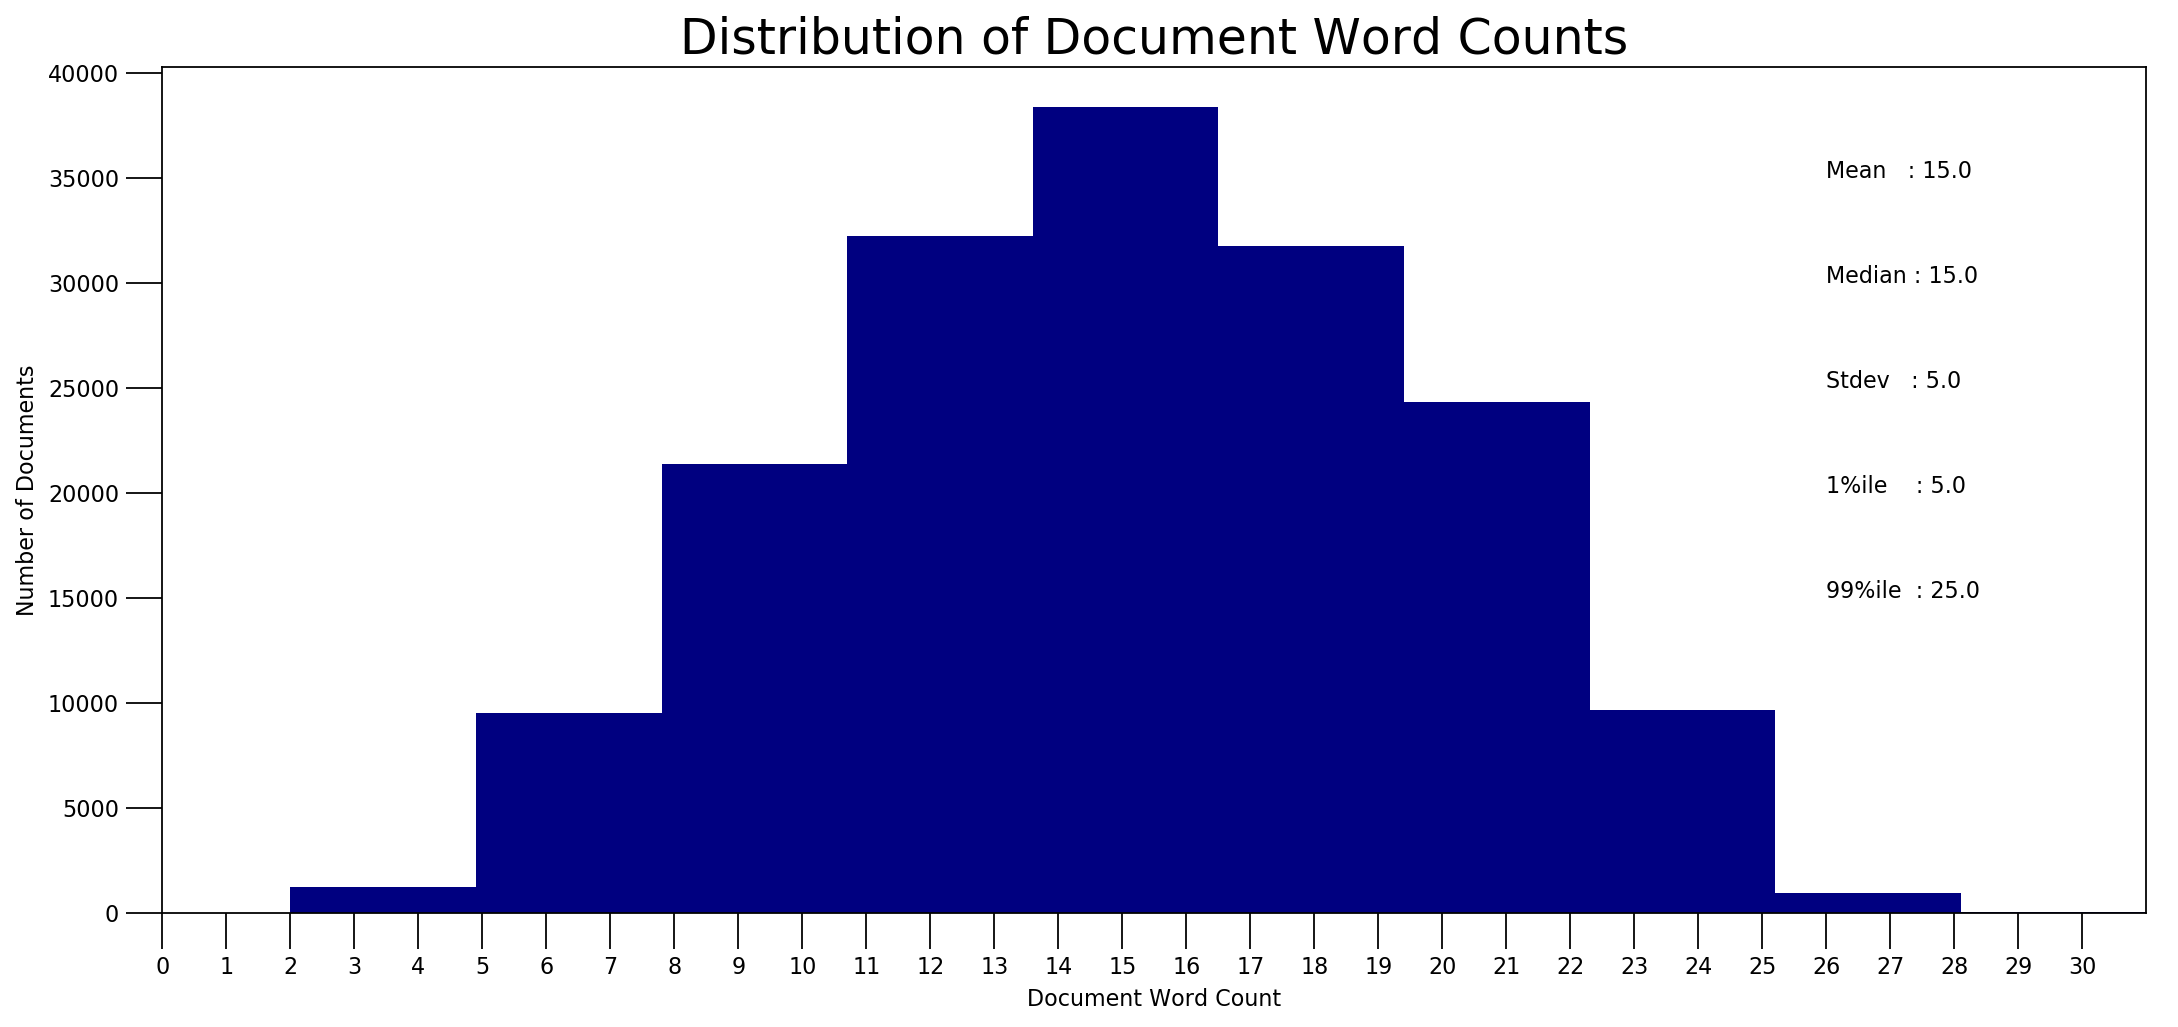

In [44]:
doc_lens = [len(d) for d in data_words]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, color='navy')
plt.text(26, 35000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(26, 30000, "Median : " + str(round(np.median(doc_lens))))
plt.text(26, 25000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(26, 20000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(26, 15000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, np.max(doc_lens)), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.arange(0,np.max(doc_lens)))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

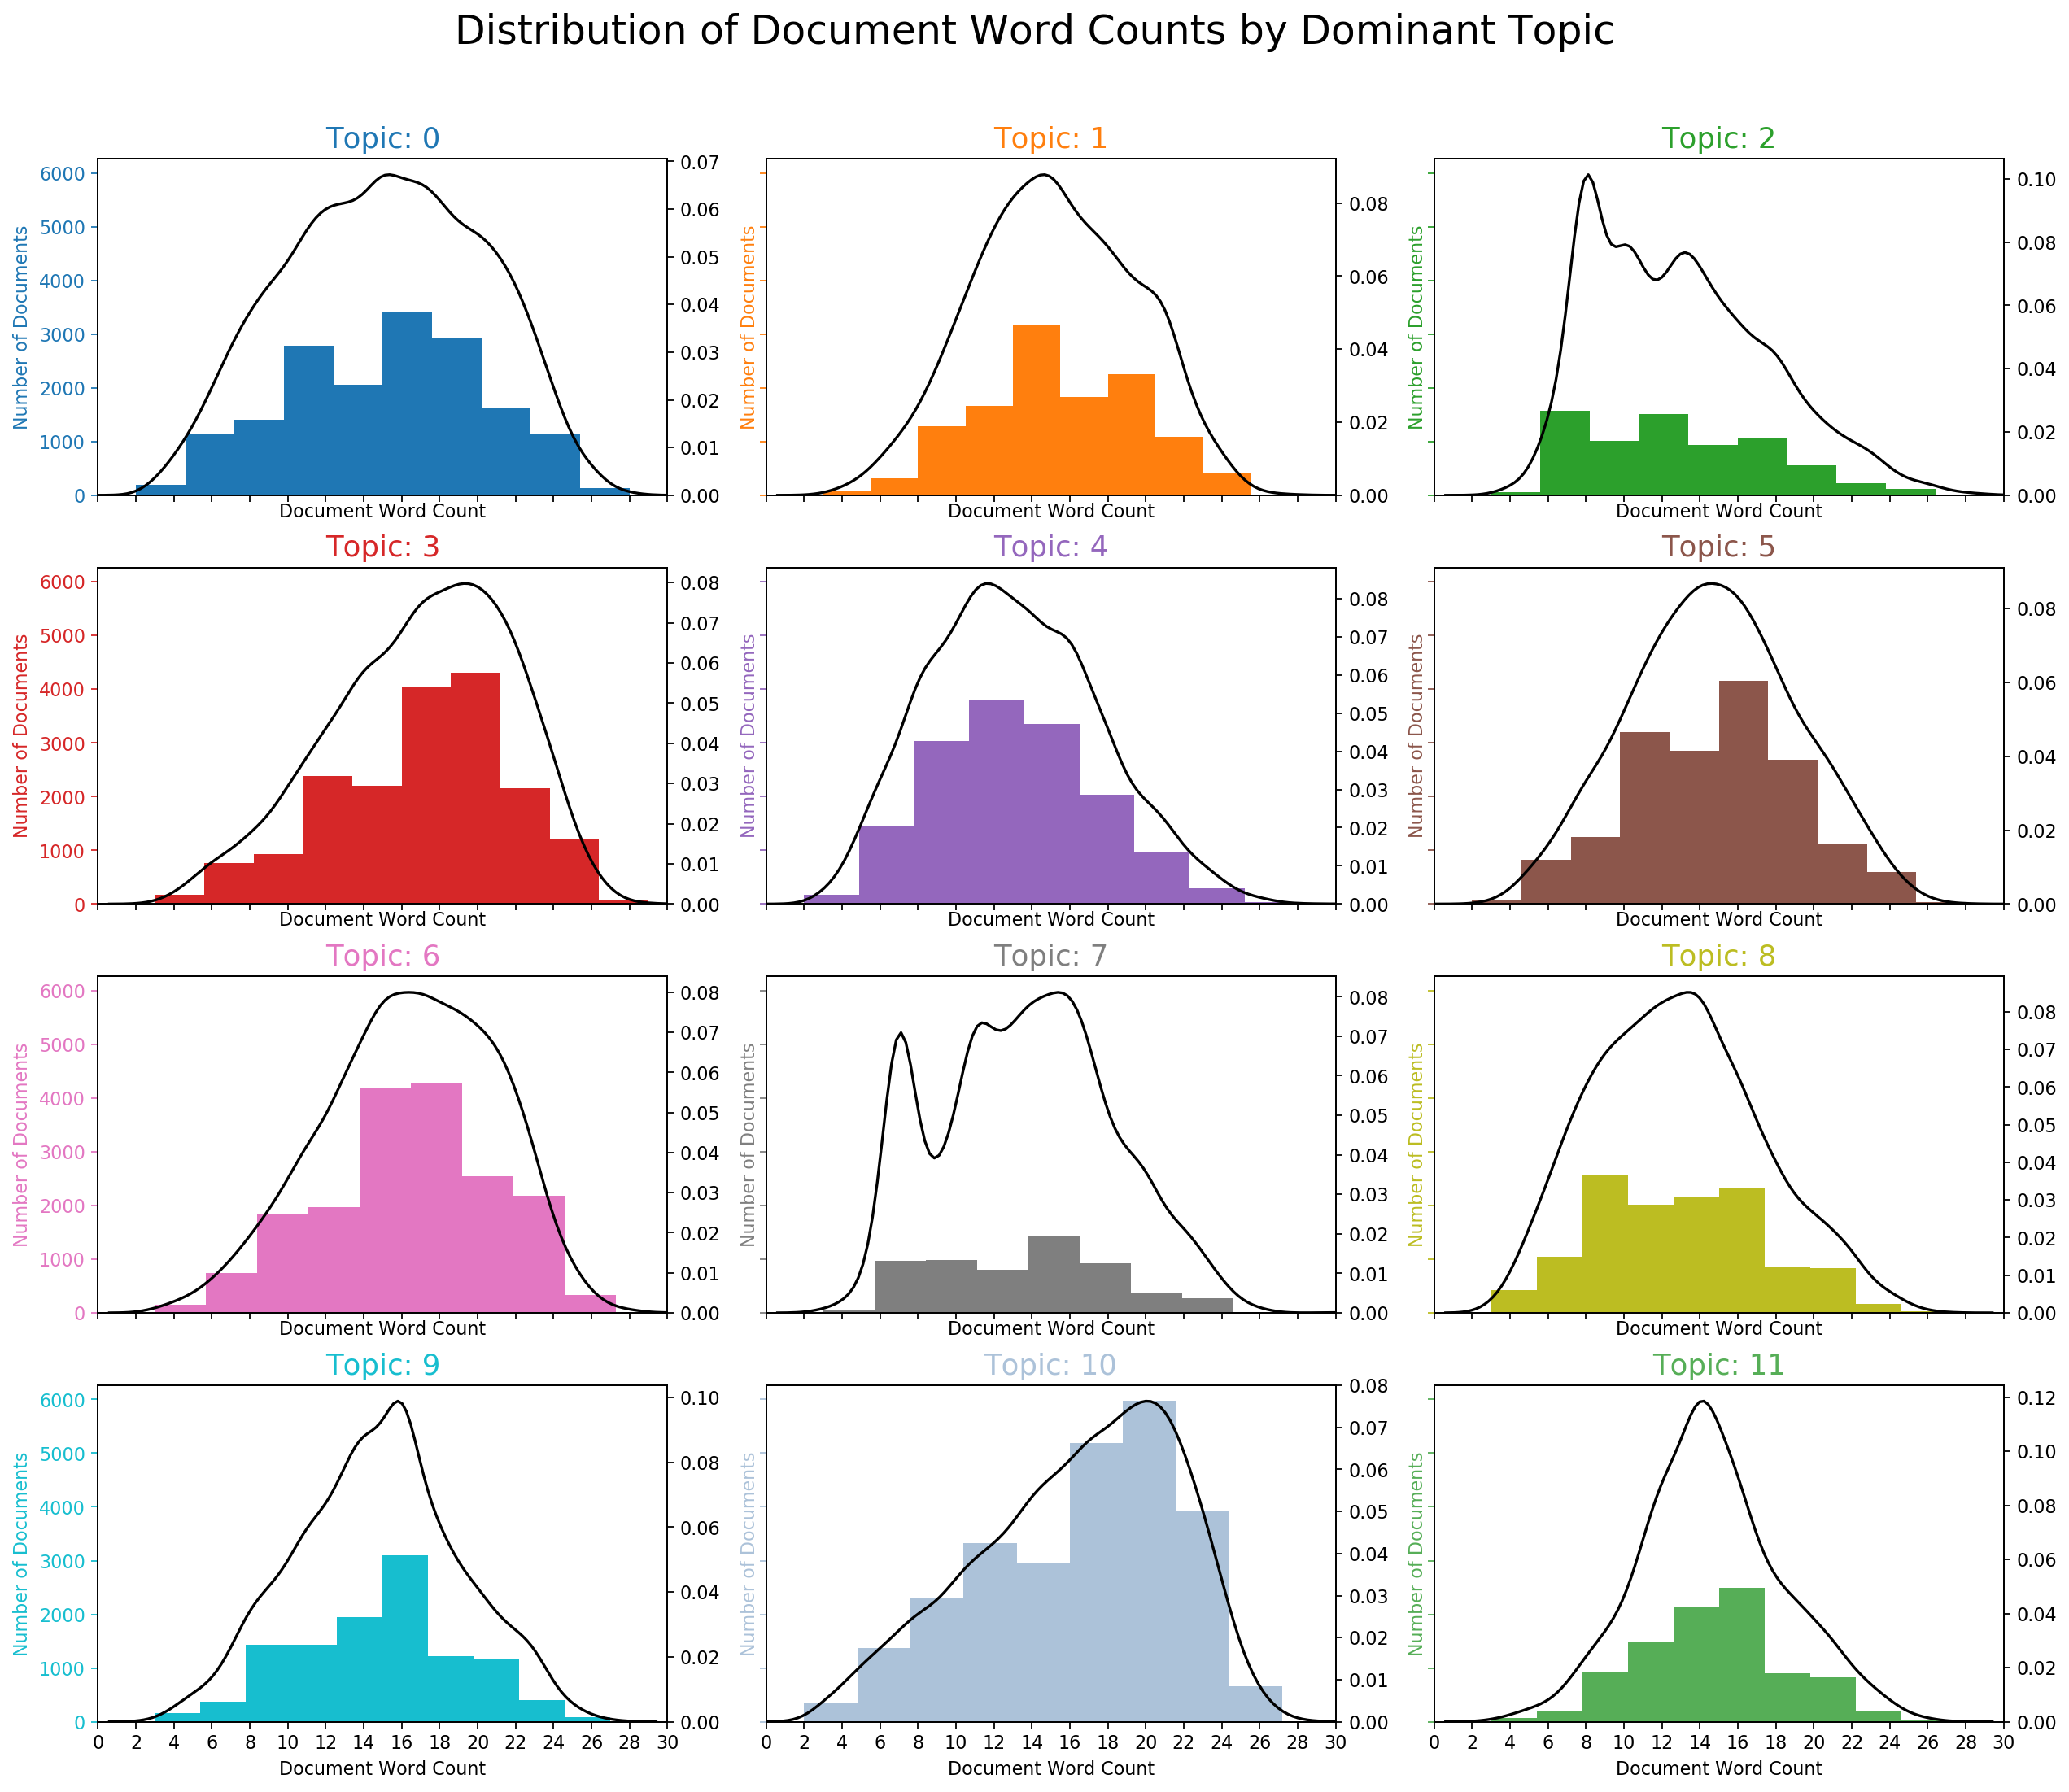

In [49]:
import seaborn as sns
import matplotlib.colors as mcolors
colors = mcolors.TABLEAU_COLORS
colors.update(mcolors.XKCD_COLORS)
cols = [color for name, color in colors.items()]  

fig, axes = plt.subplots(4,3,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Words]
    ax.hist(doc_lens, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, bw=0.8, ax=ax.twinx())
    ax.set(xlim=(0, 30), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.arange(0, 32, 2))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Cloud

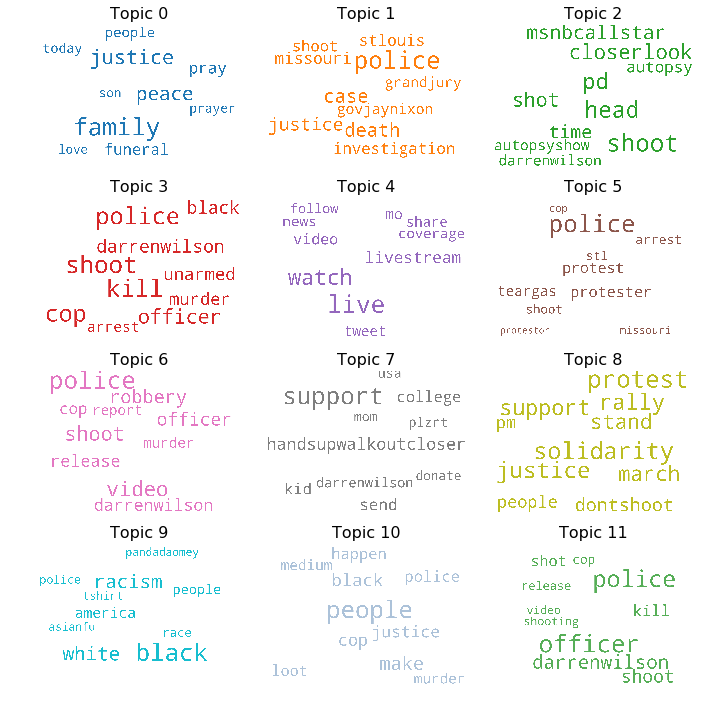

In [51]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

colors = mcolors.TABLEAU_COLORS
colors.update(mcolors.XKCD_COLORS)
cols = [color for name, color in colors.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=20)

fig, axes = plt.subplots(4, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word count of keywords

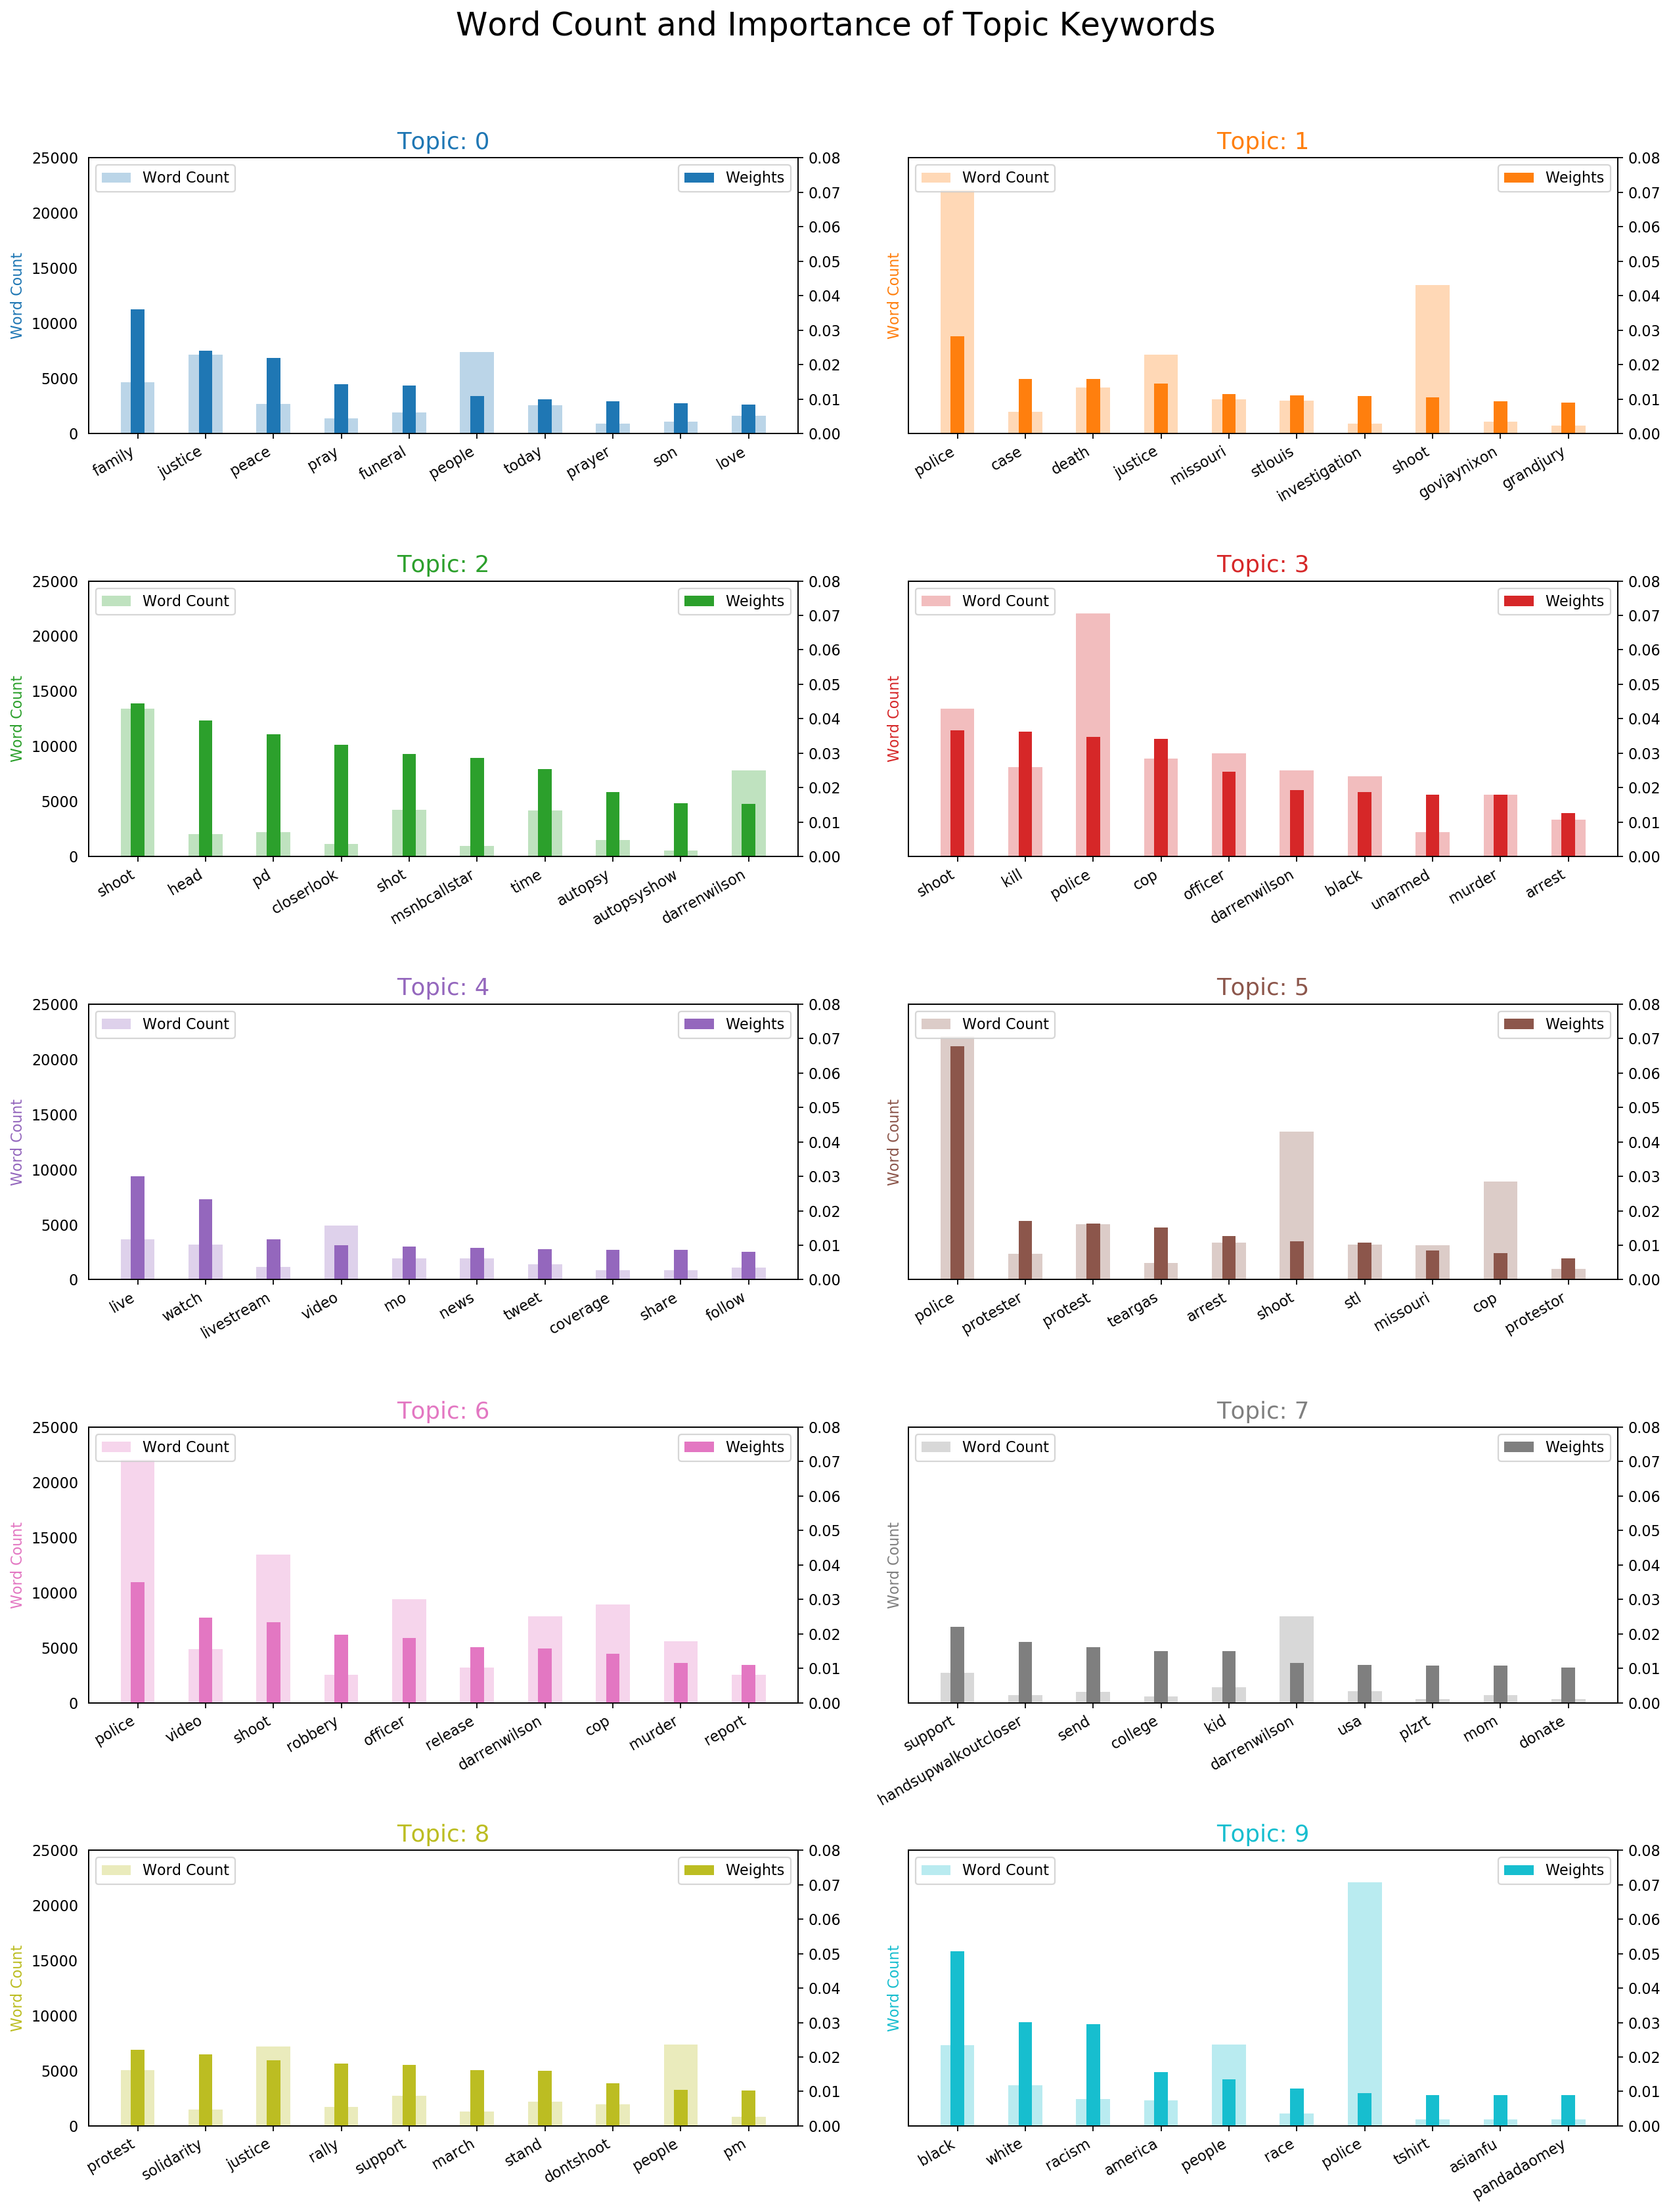

In [76]:
from collections import Counter
topics = optimal_model.show_topics(formatted=False, num_topics=20)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,20), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.08); ax.set_ylim(0, 25000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout()    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Sentence coloring

ValueError: too many values to unpack (expected 3)

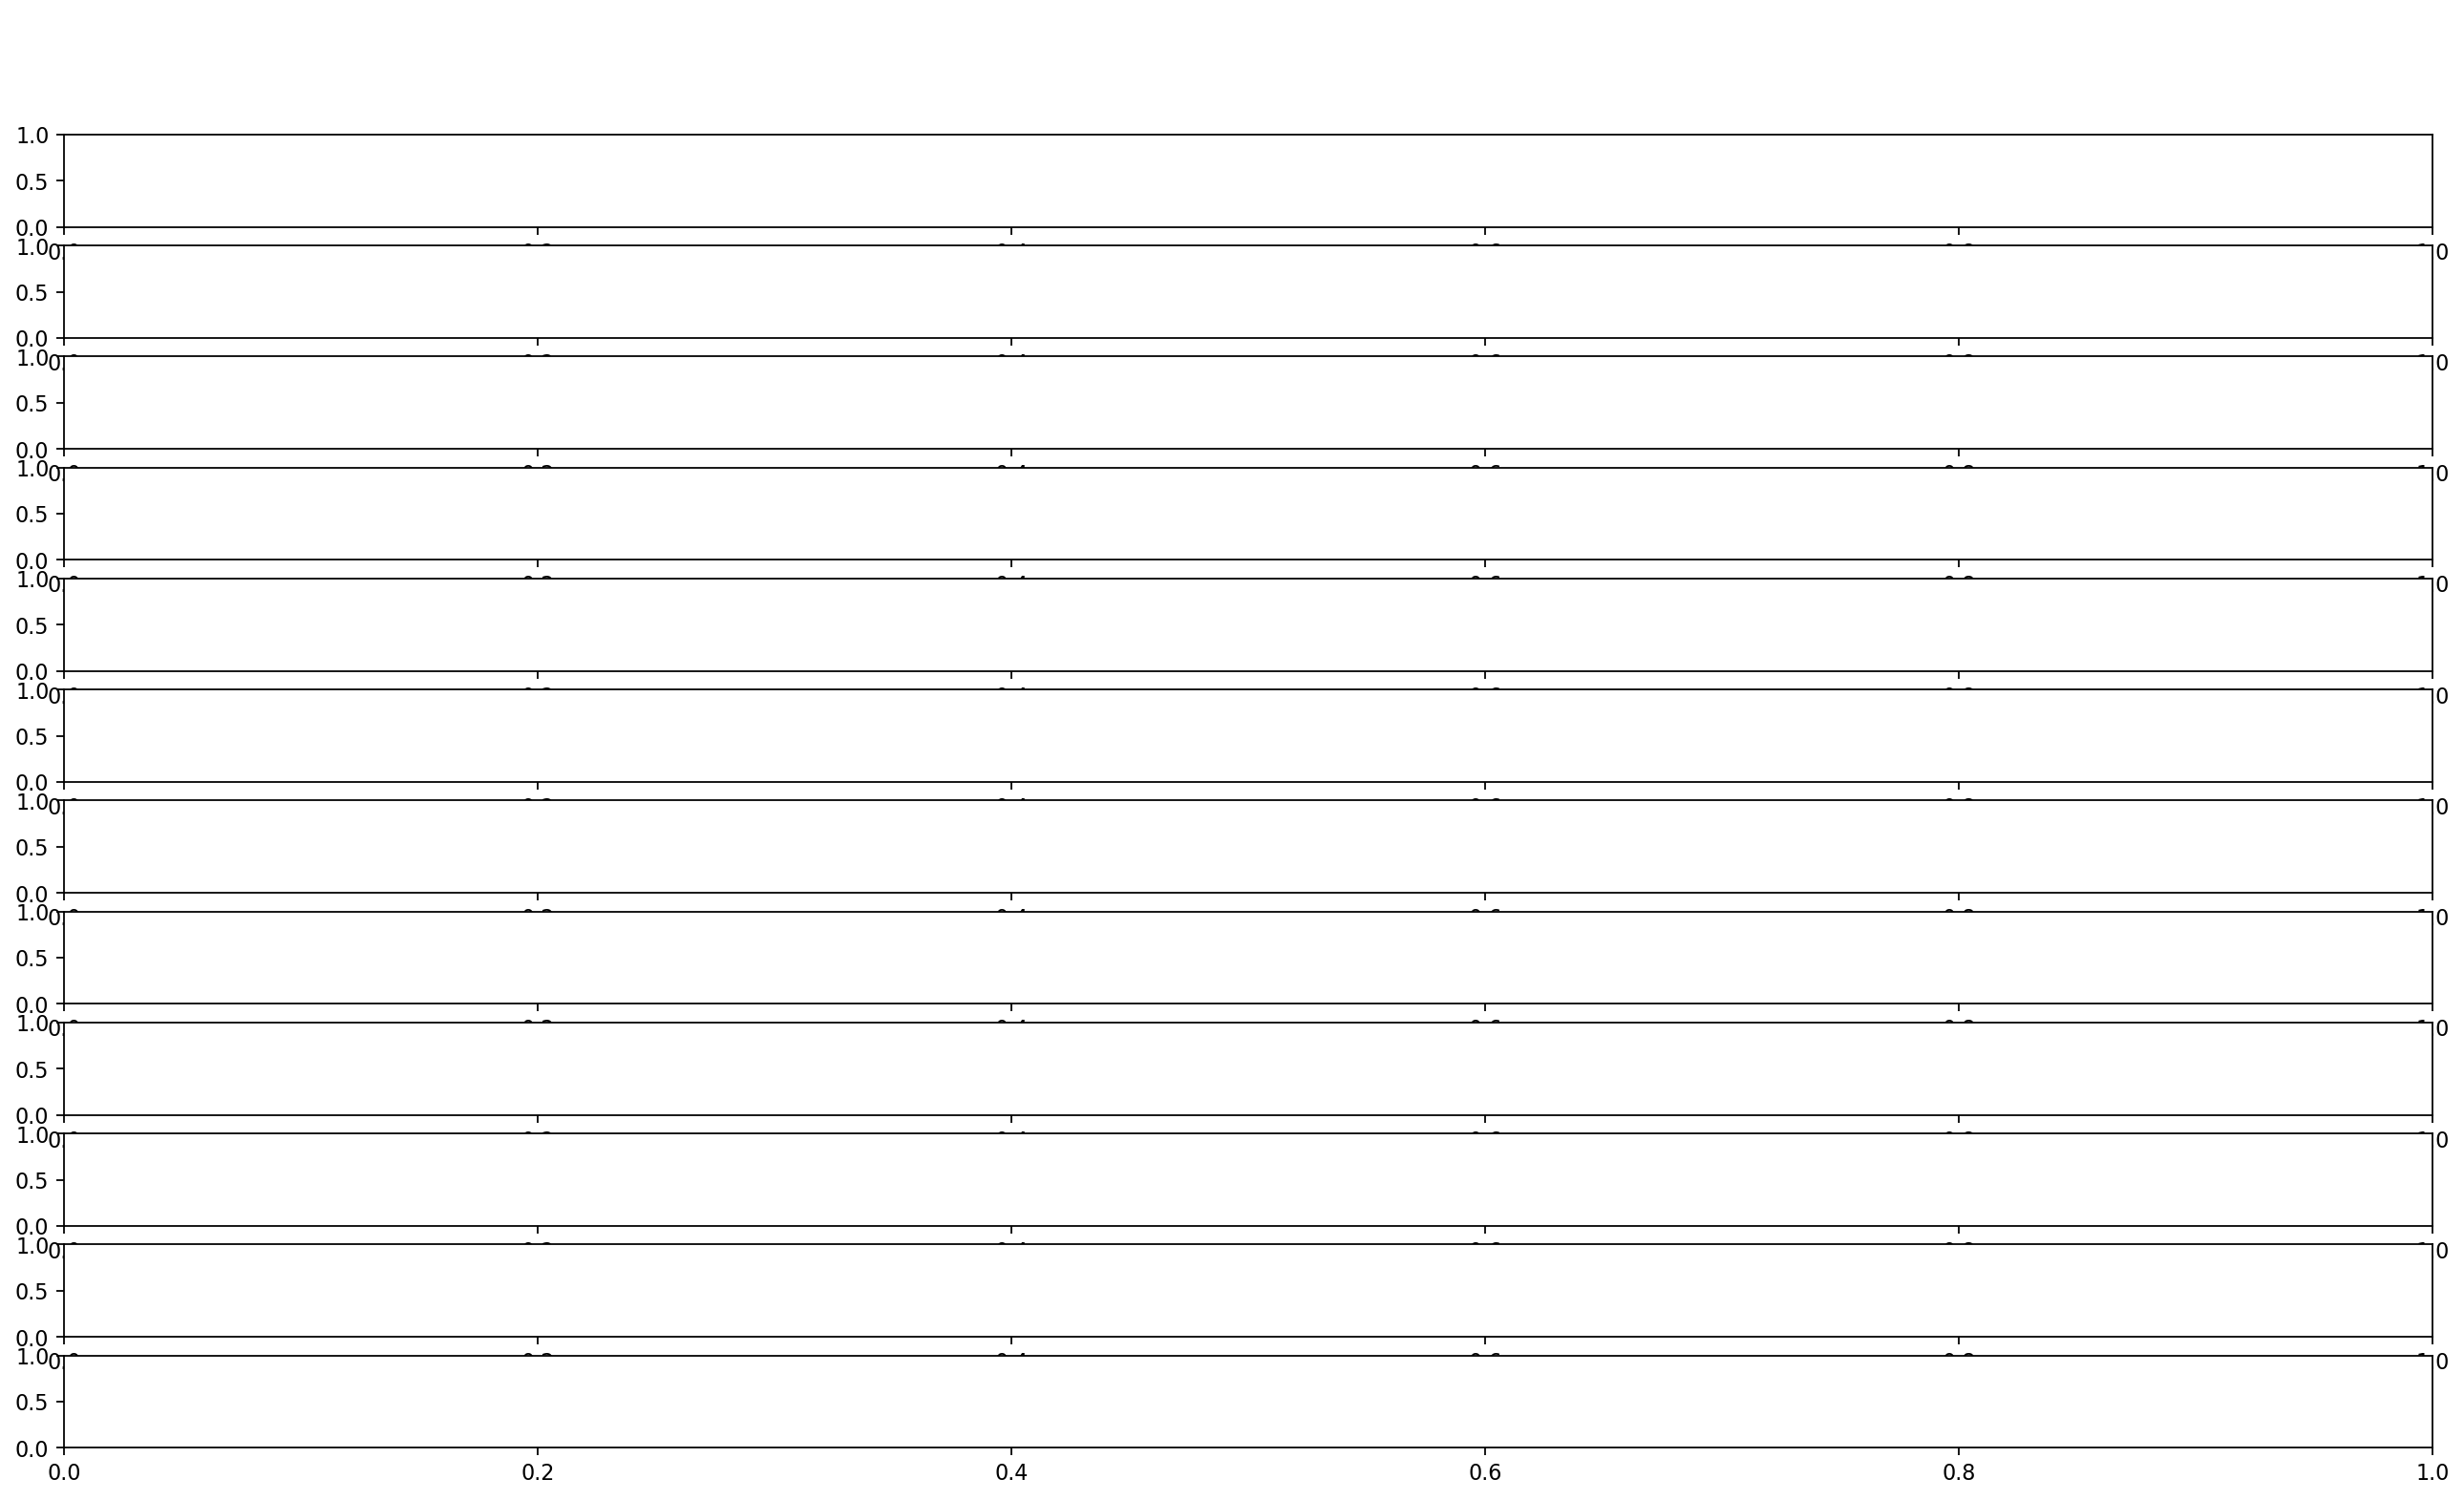

In [78]:
# Sentence Coloring
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=optimal_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart() 

In [84]:
help(optimal_model)

Help on LdaMallet in module gensim.models.wrappers.ldamallet object:

class LdaMallet(gensim.utils.SaveLoad, gensim.models.basemodel.BaseTopicModel)
 |  Python wrapper for LDA using `MALLET <http://mallet.cs.umass.edu/>`_.
 |  
 |  Communication between MALLET and Python takes place by passing around data files on disk
 |  and calling Java with subprocess.call().
 |  
 |  Warnings
 |  --------
 |  This is **only** python wrapper for `MALLET LDA <http://mallet.cs.umass.edu/>`_,
 |  you need to install original implementation first and pass the path to binary to ``mallet_path``.
 |  
 |  Method resolution order:
 |      LdaMallet
 |      gensim.utils.SaveLoad
 |      gensim.models.basemodel.BaseTopicModel
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, bow, iterations=100)
 |      Get vector for document(s).
 |      
 |      Parameters
 |      ----------
 |      bow : {list of (int, int), iterable of list of (int, int)}
 |          Document (or corpus) i

In [90]:
optimal_model.id2word[0]

'black'

In [100]:
optimal_model[corpus[4]]

[(0, 0.006069185885696898),
 (1, 0.004458403866442819),
 (2, 0.002085885639205372),
 (3, 0.006805249672458202),
 (4, 0.005380664816506781),
 (5, 0.006044533021665251),
 (6, 0.9112700310514427),
 (7, 0.001907202763488586),
 (8, 0.004245010009406391),
 (9, 0.004226865032172859),
 (10, 0.02102592261751787),
 (11, 0.026481045623996276)]

In [101]:
optimal_model[corpus[5]]

[(0, 0.008837357072688625),
 (1, 0.006491893259500415),
 (2, 0.0030372634079133265),
 (3, 0.009909141432962515),
 (4, 0.007834799784924198),
 (5, 0.008801459974393192),
 (6, 0.009273017906984073),
 (7, 0.00277708281611345),
 (8, 0.9014935919709429),
 (9, 0.023047436179948665),
 (10, 0.013723212428299221),
 (11, 0.004773743765329416)]

In [102]:
optimal_model[corpus[6]]

[(0, 0.006069185885696899),
 (1, 0.004458403866442819),
 (2, 0.002085885639205372),
 (3, 0.006805249672458202),
 (4, 0.005380664816506782),
 (5, 0.006044533021665251),
 (6, 0.7720543928000669),
 (7, 0.0019072027634885861),
 (8, 0.004245010009406391),
 (9, 0.004226865032172859),
 (10, 0.009424619429903225),
 (11, 0.17729798706298666)]